# Lecture 20: Longterm Hazard
## GEO 371T/391: Earthquakes
### Prof. Daniel Trugman, 2021

In [1]:
### Import General Python Packages

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

# Overview

This is the first of two modules on earthquake hazard, focused on longterm hazard estimation, relevant for timescales from several years to several centuries. Longterm hazard calculations are important consideration in infrastructure planning calculations, for example in the design of building codes and reinforcement of critical infrastructure like dams and power plants. In the present day, hazard calculations are usually probabilistic, running through multiple threads of analyses along with their uncertainties. 

This framework, called Probabilistic Seismic Hazard Analysis (PSHA), integrates a source or seismicity rate model, which quantifies the longterm rates of earthquake sources within the study region, and a ground motion model, which is used to predict the level of shaking for a given source-site pair. These to models are combined, with uncertainties fully propagated, to deliver the final hazard product.

This notebook illustrates two examples of the key concepts underlying PSHA. The first example gives hands on practice with a Ground Motion Prediction Equation (GMPE), the basis of the Ground Motion Models used in PSHA. The second example shows a simplified calculation of a hazard curve, which combines a seismicity rate model with a ground motion prediction equation to deliver a measure of the rate of exceedance as a function of ground motion intensity.

## Example 1: Ground Motion Prediction

In earthquake hazard analysis (whether deterministic or probabilistic), we need to know how strong the ground motion is expected to be for an earthquake of a given size as measured at a given distance. The most convenient way to represent this information is in terms of a Ground Motion Prediction Equation (GMPE), which is essentially a linear regression relation between some measure of ground motion and things like magnitude, distance, and local site effect. 

While in the early days, GMPEs were simple in functional form (not unlike the example above), in recent years they have become more and more complex. For example, consider the Boore and Atkinson (2008) GMPE, which is widely used for hazard analysis in California:

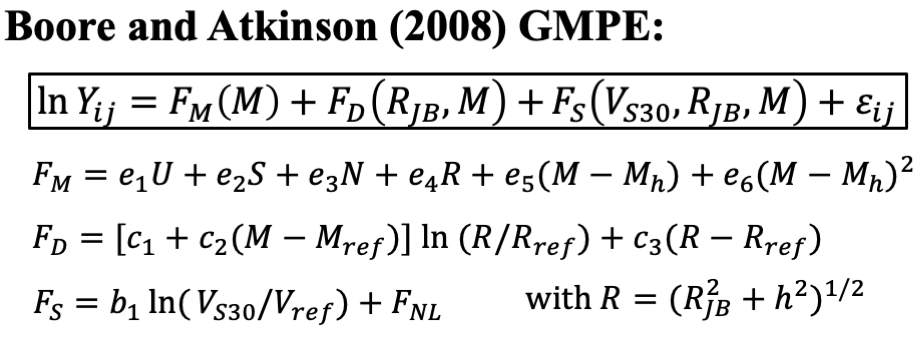

---

On the left hand side of the equation is the ground motion for earthquake i recorded at station j. 

On the right hand site, we have a whole series of terms: a (mechanism-dependent) magnitude term, a (magnitude-dependent) distance term, and a site-adjustment term (with both linear and nonlinear effects). 

This is a lot to take in all at once, but it is instructive to plot what these look like. We will do so below.

In [2]:
### Implement BA08 GMPE as a function 
# (PGA = peak ground acceleration, PGV = peak ground velocity)

def gmpe_BA08(M,Rjb,Vs30,Ftype=None,output='PGA'):
    
    ## common parameter block
    Vref = 760 # reference Vs30
    Rref = 1.0 # reference distance (km)
    Mref = 4.5 # reference magnitude
    
    ## regression model coefficients
    if output == 'PGA': # Peak Ground Acceleration
        c1, c2, c3 = [-0.66050, 0.11970,-0.01151] # distance params
        e1, e2, e3, e4, e5, e6, e7 = [            # fault/mag params
            -0.53804, -0.50350, -0.75472, 
            -0.50970, 0.28805, -0.10164, 0.00000]
        blin = -0.360 # linear site param                           
        h = 1.35 # saturation parameter
        Mh = 6.75 # hinge magnitude
        sigS, tauU, tauF = 0.502, 0.265, 0.260 # uncertainties
    
    elif output == 'PGV': # Peak Ground Velocity
        c1, c2, c3 = [-0.87370, 0.10060,-0.00334] # distance params
        e1, e2, e3, e4, e5, e6, e7 = [            # fault/mag params
            5.00121, 5.04727, 4.63188, 
            5.08210, 0.18322, -0.12736, 0.00000]
        blin = -0.600 # linear site param
        h = 2.54 # saturation parameter
        Mh = 8.50 # hinge magnitude
        sigS, tauU, tauF = 0.500, 0.286, 0.256 # uncertainties
    else:
        print('Regression coefficients not yet defined.')
        raise KeyboardInterrupt
    
    ## output size
    nout = M.size
    assert Rjb.size == Vs30.size == nout
    yout = np.zeros(nout)
    
    ## mechanism calculation
    if Ftype is None: 
        yout += e1
    else:
        cF = [e1,e2,e3,e4]
        yout += np.array([cF[Ftype[ii]-1] for ii in range(nout)])
    
    # magnitude calculation    
    yout += np.where(M<Mh,e5*(M-Mh)+e6*(M-Mh)**2,e7*(M-Mh))
    
    ## distance calculation
    R = np.sqrt(Rjb**2+h**2)
    yout += (c1 + c2*(M-Mref))*np.log(R/Rref) + c3*(R-Rref)
    
    ## site calculation
    yout += blin*np.log(Vs30/Vref)
    
    # return output vector and uncertainties
    return yout, (sigS,tauU,tauF)

(351,)
(351,)
(351,)


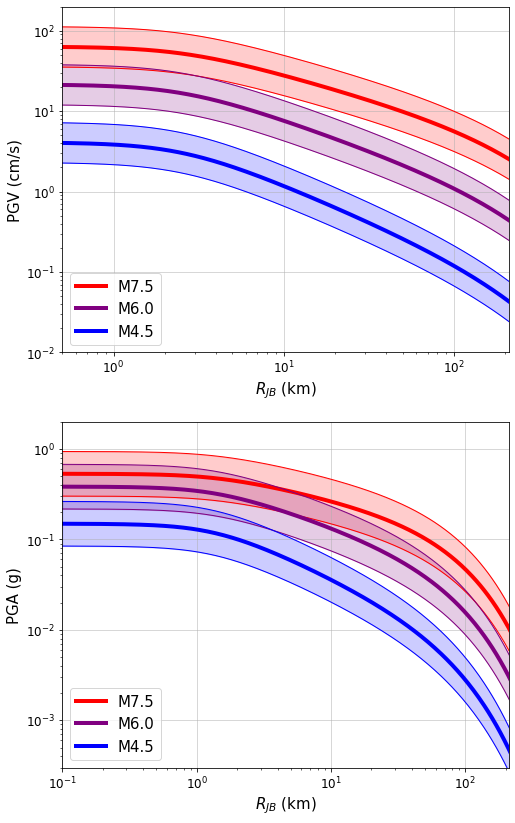

In [3]:
### Plot results for PGA and PGV

# data parameters
mags = [7.5,6.0,4.5]
colors = ['red','purple','blue']
ndata = 351
Rvec = np.logspace(-1.0,2.5,ndata)
Vvec = np.zeros(ndata) + 760 # neutral site condition
Fvec = np.ones(ndata,dtype='int')

# plot setup
fig, axs = plt.subplots(2,1,figsize=(8,14))

# ---- PGV Plot -----#
axi = axs[0]

# loop over magnitudes
for ii, mag in enumerate(mags):
    
    # calculate ground motions
    Mvec = np.zeros(ndata) + mag
    log_PGV, uc_PGV = gmpe_BA08(Mvec,Rvec,Vvec,Fvec,'PGV')
    l10_PGV = log_PGV/np.log(10)
    s10_PGV = np.sqrt(uc_PGV[0]**2+uc_PGV[1]**2)/np.log(10) #within and between event
    
    # plot data and uncertainties
    color = colors[ii]
    axi.fill_between(Rvec,10**(l10_PGV-1*s10_PGV),10**(l10_PGV+1*s10_PGV),
                   color=color,alpha=0.2,zorder=-1)
    axi.plot(Rvec,10**(l10_PGV),'-',color=color,lw=4,label='M{:.1f}'.format(mag))
    axi.plot(Rvec,10**(l10_PGV-1*s10_PGV),'-',color=color,lw=1)
    axi.plot(Rvec,10**(l10_PGV+1*s10_PGV),'-',color=color,lw=1)

# axes limits
axi.set_xscale('log')
axi.set_yscale('log')
axi.set_xlim(0.5,210)
axi.set_ylim(1e-2,2e2)
axi.grid(lw=0.5)

# axes labels
axi.set_xlabel('$R_{JB}$ (km)',fontsize=15)
axi.set_ylabel('PGV (cm/s)',fontsize=15)
axi.tick_params(labelsize=12)
axi.legend(loc='lower left',fontsize=15)

# ---------------- #

# ---- PGA Plot -----#

axi = axs[1]

# loop over magnitudes
for ii, mag in enumerate(mags):
    
    # calculate ground motions
    Mvec = np.zeros(ndata) + mag
    print(Mvec.shape)
    log_PGA, uc_PGA = gmpe_BA08(Mvec,Rvec,Vvec,Fvec,'PGA')
    l10_PGA = log_PGA/np.log(10)
    s10_PGA = np.sqrt(uc_PGA[0]**2+uc_PGA[1]**2)/np.log(10) #within and between event
    
    # plot data and uncertainties
    color = colors[ii]
    axi.fill_between(Rvec,10**(l10_PGA-1*s10_PGA),10**(l10_PGA+1*s10_PGA),
                   color=color,alpha=0.2,zorder=-1)
    axi.plot(Rvec,10**(l10_PGA),'-',color=color,lw=4,label='M{:.1f}'.format(mag))
    axi.plot(Rvec,10**(l10_PGA-1*s10_PGA),'-',color=color,lw=1)
    axi.plot(Rvec,10**(l10_PGA+1*s10_PGA),'-',color=color,lw=1)

# axes limits
axi.set_xscale('log')
axi.set_yscale('log')
axi.set_xlim(0.1,210)
axi.set_ylim(3e-4,2e0)
axi.grid(lw=0.5)

# axes labels
axi.set_xlabel('$R_{JB}$ (km)',fontsize=15)
axi.set_ylabel('PGA (g)',fontsize=15)
axi.tick_params(labelsize=12)
axi.legend(loc='lower left',fontsize=15)


# show
plt.show()
plt.close()

---

The top plot shows Peak Ground Velocity (PGV), while the bottom plot shows Peak Ground Acceleration (PGA), plotted versus distance for few different earthquake sizes. To get a feel for this, it may be helpful to adjust some of the plotting parameters (e.g., different earthquake sizes, distance range, site condition, mechanism).

**Question 1(a)**

The x-label for these plots is $R_{JB}$. Any guesses what that refers to? More generally, what are different ways one could measure the distance between an earthquake and a site? How might that affect ground motion?

In [4]:
# [enter group answers here]

**Question 1(b)** 

Look closely at the shapes of the curves for PGV and PGA. What are the differences you notice? What do you think causes them?

In [5]:
# [enter group answers here]

**Question 1(c)** 

Why do these curves flatten off at close distances?

In [6]:
# [enter group answers here]

**Question 1(d)** 

These calculations pertain to a "neutral" site condition. How would the curves shift for a site on hard rock or soft sediments? What might happen for the very largest of earthquakes at near-source distances?

In [7]:
# [enter group answers here]

**Question 1(e)**

The implementation above gives formulas for PGA and PGV. In many cases, we may be more interested in a quantity called the _response spectrum_. What do you think that refers to, and why is it important for PSHA?

In [8]:
# [enter group answers here]

**Question 1(f)**

Likewise, humans are most sensitive to measure of shaking intensity like MMI, rather than the peak ground motion itself. How could we convert PGA and PGV into a measure of intensity?

In [9]:
# [enter group answers here]

## Example 2: Hazard Curves

To obtain a measure of earthquake hazard, one must combine the ground motion model with a seismicity rate model that quantifies longterm rates of earthquake sources (locations and magnitudes) through the region of interest. One important metric used in PSHA is called a _hazard curve_, which quantifies, for a single site, the probability of exceeding different threshold values of ground motion over some time horizon. This example, adapted from Ned Field's excellent tutorial on PSHA, will walk you through the basic calculation under some simplified assumptions.


**Ground Motion Model**

For simplicity, let us consider a ground motion model of the form:

\begin{equation}
\ln PGA = 0.53 (M-6) - 0.39 \ln(R^2 + 31) + 0.25. 
\end{equation}

This is the Boore, Joyner, Fumal (1997) GMPE for strike-slip events and soil site conditions.

---

A good rule of thumb is that the standard deviation $\sigma$ of $\ln PGA$ is about 0.5 (0.52 in this case), with values normally distributed about the center prediction.

Thus, we reformulate the GMPE into a probabalistic framework assuming a Gaussian distribution of the form:

\begin{equation}
p(\ln PGA | M, R) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left[\frac{-(\ln PGA - g(M,R))^2}{2 \sigma^2} \right], 
\end{equation}

where $g(M,R)$ is our chosen GMPE.



---

**The Survival Function**

To calculate a hazard curve, we need to know the probability $P$ of exceeding each value of PGA, which can be obtained through an integral of the form:

\begin{equation}
P(>\ln PGA) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{\ln PGA}^{\infty} \exp \left[\frac{-(\ln PGA - g(M,R))^2}{2 \sigma^2} \right] d \, lnPGA
\end{equation}

For the Gaussian distribution, this integral is straightforward to compute numerically and is sometimes called a _survival distribution_. It is the complement to the _cumulative distribution_ you may have studied in statistics class.

---

**Putting it all together**

Now, consider a site of interest and a scenario earthquake of magnitude $M_i$ and distance $R_i$ from the site. Assuming this event does indeed occur, then we have a probalility $P_i$:

\begin{equation}
P_i(>\ln PGA) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{\ln PGA}^{\infty} \exp \left[\frac{-(\ln PGA - g(M_i,R_i))^2}{2 \sigma^2} \right] d\ln PGA
\end{equation}

Of course, we don't know a-priori that this earthquake scenario will in fact take place. In general, we might consider $N$ earthquake scenarios, each with annual rates of occurrence $q_i$. 

Then the total hazard curve is given by a weighted sum of all of these scenarios:

\begin{equation}
H(\ln PGA) = \sum_{i=1}^{N} q_i P_i (> \ln PGA) 
\end{equation}

The interpretation of $H(\ln PGA)$ is that is the total annual rate of exceeding $\ln PGA$ at this site, considering all possible earthquake scenarios and their probabilities.

---

**Application**

To see how this works in practice, consider a source model compose of $N=2$ scenarios. The first is a M6 earthquake that occurs every 22 years, and the second is a M7.8 earthquake that occurs every 300 years. Both are strike-slip events located $R=10$ km away from the site.

We can compute the hazard curve as follows using Python.

In [10]:
### First, compute expected lnPGA

# implement gmpe
def gmm(M,R):
    return 0.53*(M-6) - 0.39*np.log(R**2+31) + 0.25

# earthquake 1
g1 = gmm(6.0,10)
print(g1)

# earthquake 2
g2 = gmm(7.8,10)
print(g2)



-1.651326956048449
-0.697326956048449


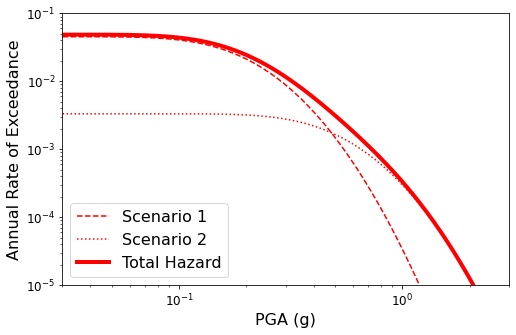

In [11]:
### Hazard curve calculation

# we will use scipy.stats for the survival function
from scipy import stats

# setup
q1 = 1.0/22.0 # scenario 1 rate
q2 = 1.0/300.0 # scenario 1 rate
sig = 0.52 # GMM uncertainty

# compute hazard curve for these values of PGA
pga_vals = np.logspace(-2,1.5,701)

# Survival function integral for earthquake 1
P1_vals = stats.norm.sf(np.log(pga_vals),
                  loc=g1,scale=sig)

# Survival function integral for earthquake 2
P2_vals = stats.norm.sf(np.log(pga_vals),
                  loc=g2,scale=sig)

# figure setup
fig, ax = plt.subplots(figsize=(8,5))

# plot 
ax.loglog(pga_vals, q1*P1_vals,"--r",
         label="Scenario 1")
ax.loglog(pga_vals, q2*P2_vals,":r",
         label="Scenario 2")
ax.loglog(pga_vals, q1*P1_vals+q2*P2_vals,
          "-r", lw=4,label="Total Hazard")

# formatting
ax.set_xlabel("PGA (g)",fontsize=16)
ax.set_ylabel("Annual Rate of Exceedance",fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xlim(3e-2,3e0)
ax.set_ylim(1e-5,1e-1)
ax.legend(loc="lower left",fontsize=16)

# show plot
plt.show()
plt.close()

---

In this example, you can see the lower values of PGA are dominantly contributed by Scenario 1, which occurs more frequently, while the higher values of PGA are dominantly contributed by Scenario 2, which is the only event large enough to access such strong levels of shaking. This type of breakdown of total hazard into the contributing scenarios is called _deaggregation_.

**Questions**

* In general, we are likely to encounter more scenarios than just two. How could we accomodate this in our code above?

* How might one devise a full listing of realistic scenarios for the site of interest? Need all the sources be located at 10km distance? How far away do we need to consider hypothetical earthquake sources?

* Does this framework account for aftershocks triggered by the M7.8 and M6.0? Why or why not? Are they likely to be important?

* What would happen if our site was located on hard rock rather than soil? What if it was in a deep sedimentary basin? Is this accounted for in our model in any way?

In [12]:
# [enter group answers here]